***
# Cryogenic Detector Data Augmentation
***

*Correspondence to: felix.wagner@oeaw.ac.at*

In this notebook we explore the data augmentation module of the Cait Python package. We are going to simulate a dataset of realistic events, including two different pulse shapes (absorber and carrier recoils), and a set of artifacts.

In [16]:
from cait.augment import ParameterSampler, plot_events, unfold, L2
import numpy as np
import cait as ai  # install from the develop branch
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
from tqdm.auto import tqdm
from scipy import signal
from sklearn.ensemble import RandomForestClassifier
%config InlineBackend.figure_formats = ['svg']

Some definitions for the plots.

In [2]:
mpl.rcParams['figure.figsize'] = (7.2, 4.45)
mpl.rcParams['savefig.dpi'] = 300

Define the global parameters. These define the most important info about the augmented data: Record length, sample frequency and resolution (standard deviation) of the noise.

There is also the possibility to add polynomial drift structures to the baselines, which we observe in measured baselines very often. The rasterization feature introduces a discrete sampling effect, as we would observe it from the 16 bit precision of the digitizer. The saturation applies a saturation curve to all events, as it would happen in any real TES measurement.

The class names list includes the names of all classes that we want to simulate in the dataset. These are all the classes that are currently available within `cait`.

For the whole notebook: Only capitalized parameters need to be set by the user.

In [3]:
RECORD_LENGTH = 16384
SAMPLE_FREQUENCY = 25000
RESOLUTION = 0.003

POLYNOMIAL_DRIFTS = True
RASTERIZE = True
SQUARE_WAVES = False
SATURATION = True
CLASS_NAMES = ['Event Pulse',
               'Noise',
               'Decaying Baseline',
               'Temperature Rise',
               'Spike',
               'Squid Jump',
               'Reset',
               'Cosinus Tail',
               'Decaying Baseline with Event Pulse',
               'Pile Up',
               'Early or late Trigger',
               'Carrier Event',
               'Decaying Baseline with Tail Event',
               ]


# ----------------------------------------- 
# no need to change below parameters
# ----------------------------------------- 

label_names = {
    'unlabeled': 0,
    'Event Pulse': 1,
    'Test/Control Pulse': 2,
    'Noise': 3,
    'Squid Jump': 4,
    'Spike': 5,
    'Early or late Trigger': 6,
    'Pile Up': 7,
    'Carrier Event': 8,
    'Strongly Saturated Event Pulse': 9,
    'Strongly Saturated Test/Control Pulse': 10,
    'Decaying Baseline': 11,
    'Temperature Rise': 12,
    'Stick Event': 13,
    'Square Waves': 14,
    'Human Disturbance': 15,
    'Large Sawtooth': 16,
    'Cosinus Tail': 17,
    'Light only Event': 18,
    'Ring & Light Event': 19,
    'Sharp Light Event': 20,
    'Reset': 21,
    'Decaying Baseline with Event Pulse': 22,
    'Decaying Baseline with Tail Event': 23,
    'unknown/other': 99,
}

Initializa an instance of the sampler class. This class is responsible for the simulation of all event, but we need to set all the arguments. Otherwise the arguments will be randomly sampled (see notebook `Universal Training Set`).

In [4]:
parsam = ParameterSampler(record_length=RECORD_LENGTH,
                          sample_frequency=SAMPLE_FREQUENCY)

We define the detector resolution. The measured resolution will deviate from the set resolution, depending on the noise power spectrum and the method for reconstructing the resolution.

In [5]:
parsam.set_args(resolution=np.array([RESOLUTION]))

We define the pulse shapes. You can either ask the ParameterSampler instance to generate some shapes randomly (you can always resample, in case you don't like them), or you put your own parameters. The pulses follow the pulse shape model for cryogenic TES detectors, introduced by Franz Pröbst. In the cell below, we commented to option to randomly sample pulse shapes out, but you can always uncomment it (and comment the "define your own" section instead).

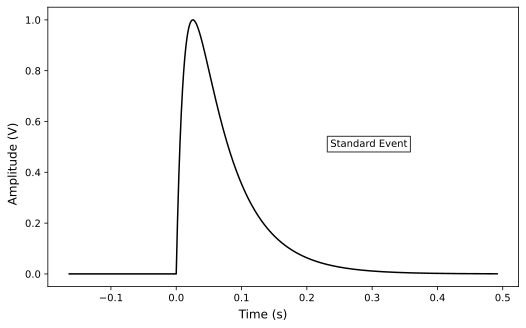

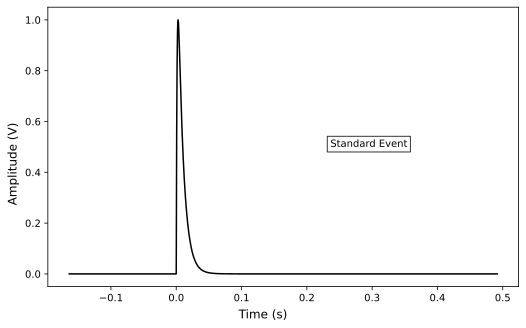

In [6]:
# sample pulse shapes

# ps1, _ = parsam.sample_pulse_par(size=1, t0=np.array([0.]))
# ps2, _ = parsam.sample_pulse_par(size=1, t0=np.array([0.]))
# print(ps1)
# print(ps2)

# or define your own pulse shapes ...
ps1 = {'t0': np.array([0.]), 
       'tau_t': np.array([0.05815608]), 
       'tau_in': np.array([0.02059209]), 
       'tau_n': np.array([0.01395427]), 
       'An': np.array([-0.02508469])/0.0715207609981429, 
       'At': np.array([0.14102789])/0.0715207609981429}
ps2 = {'t0': np.array([0.]), 
       'tau_t': np.array([0.01730027]), 
       'tau_in': np.array([0.00128385]), 
       'tau_n': np.array([0.00815371]), 
       'An': np.array([2.59789859])/1.553262177826752,
       'At': np.array([0.02694577])/1.553262177826752}

for i,p in enumerate([ps1, ps2]):

    event = ai.fit.pulse_template(parsam.t, **unfold(p, 1))
    plot_events(event.reshape(1,-1), t=parsam.t, show=True, text=['Standard Event'])
    
parsam.set_args(pulse_shapes=[[ps1['t0'], ps1['An'], ps1['At'], ps1['tau_n'], ps1['tau_in'], ps1['tau_t']],
                              [ps2['t0'], ps2['An'], ps2['At'], ps2['tau_n'], ps2['tau_in'], ps2['tau_t']],
                              ])

We define the noise power spectrum, with randomly sampled parameters. You can always resample, in case you don't like it.

The noise power spectrum follows a parametric shape: Two $1/f^a$ functions are superposed, with $a$ sampled in between 1 and 2. The constant component is forced to zero. A low pass filter starts above 1e4 Hz. The characteristic 50 Hz Peak, including its first and second harmonic, are sampled with heights relative to the overall NPS height.

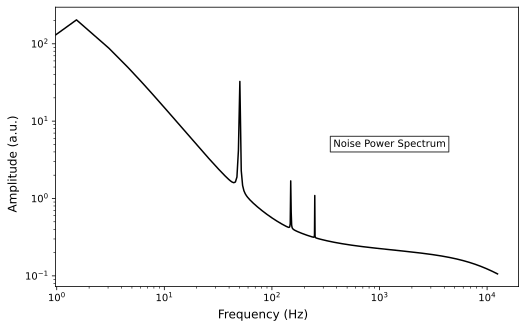

In [7]:
# sample nps

parsam.set_args(nps=None)

noise_par, info = parsam.sample_noise(size=1)

# or define your own nps ...
# noise_par['nps'] = nps[:, 1].reshape(1,-1)
# info['fq'] = np.fft.rfftfreq(n=RECORD_LENGTH, d=1 / SAMPLE_FREQUENCY)

# plot begin -------

plt.close()

fig, ax = plt.subplots(constrained_layout=True)

ax.loglog(info['fq'], noise_par['nps'][0], color='black', linewidth=1.5, zorder=50)

# eye guidelines

fig.supxlabel('Frequency (Hz)')
fig.supylabel('Amplitude (a.u.)')
ax.text(x=.6,y=.5,s='Noise Power Spectrum', 
        transform=ax.transAxes,
        bbox=dict(boxstyle='square', fc='white', alpha=0.8, ec='k'))
plt.show()

parsam.set_args(nps=noise_par['nps'])

We define the saturation curve. It is modeled with a generalized logistics function, we put some parameters explicitely, but you can also randomy sample new ones.

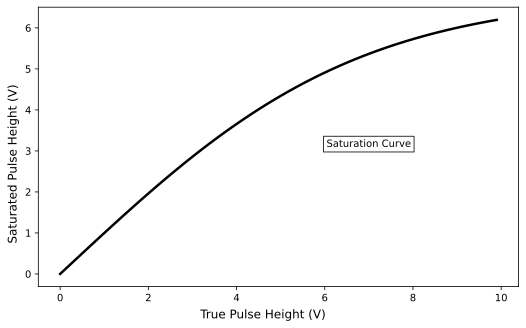

In [8]:
# sat = parsam.sample_saturation(size=1)
# print(sat)

# or define your own saturation ...
sat = {'K': np.array([8.8786987]),
       'C': np.array([1.23606841]),
       'Q': np.array([2.12402435]),
       'B': np.array([0.57876924]),
       'nu': np.array([1.61744008]),
       'A': np.array([-7.95906284])}

plt.close()

fig, ax = plt.subplots(constrained_layout=True)

ax.plot(np.arange(0, 10, 0.1), ai.fit.scaled_logistic_curve(np.arange(0, 10, 0.1), **sat), color='black', linewidth=2.5)
fig.supxlabel('True Pulse Height (V)')
fig.supylabel('Saturated Pulse Height (V)')

ax.text(x=.6,y=.5,s='Saturation Curve', transform=ax.transAxes,
        bbox=dict(boxstyle='square', fc='white', alpha=0.8, ec='k'))

plt.show()

parsam.set_args(saturation_pars=sat)

Now we are ready to plot some augmented events!

Event Pulse


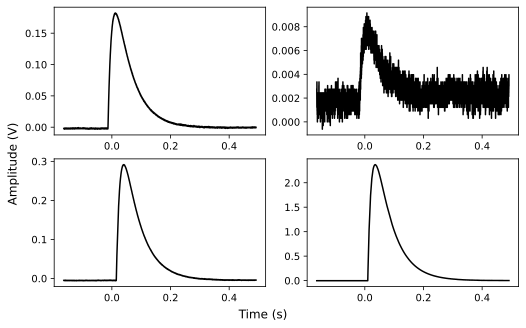

Resolution (only meaningful without Saturation):  0.031268445128400824
Noise


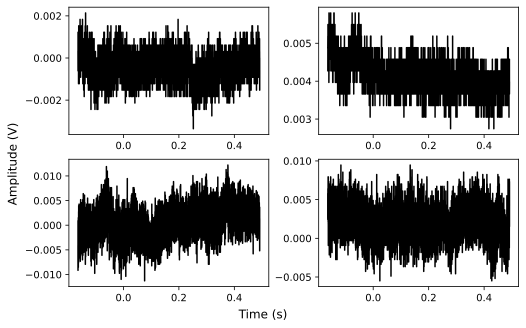

Carrier Event


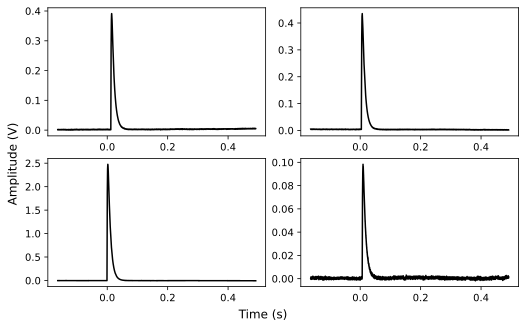

Reset


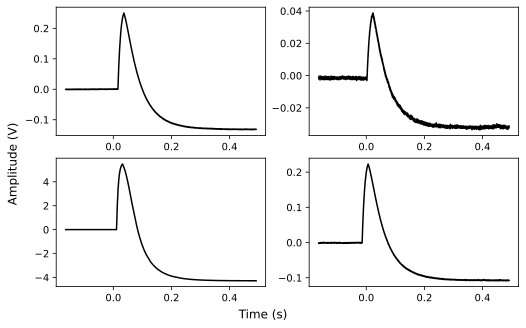

Squid Jump


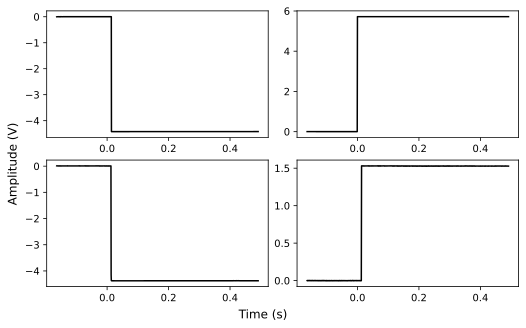

Pile Up


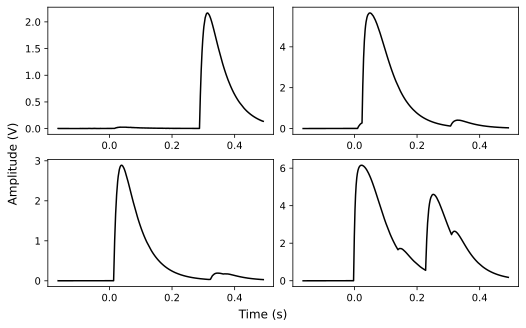

In [9]:
NMBR_PLOTS = 6

classes = np.random.choice(CLASS_NAMES, size=NMBR_PLOTS)
classes[0] = CLASS_NAMES[0]
classes[1] = CLASS_NAMES[1]
classes[2] = CLASS_NAMES[11]
# classes = [CLASS_NAMES[0] for i in range(NMBR_PLOTS)]

for i in range(NMBR_PLOTS):

    event, info = parsam.get_event(label=classes[i],
                                   size=4,
                                   rasterize=RASTERIZE,
                                   poly=POLYNOMIAL_DRIFTS,
                                   square=SQUARE_WAVES,
                                   saturation=SATURATION,
                                   verb=False,
                                   )

    print(classes[i])
    plot_events(event, t=parsam.t)
    if classes[i] == 'Event Pulse':
        print('Resolution (only meaningful without Saturation): ', np.std(np.abs(np.max(event, axis=1) - info['pulse_height'])))

Now we are ready to create an HDF5 data set with these simulated events!

To change the number of simulated events, change the EVENTS_PER_CLASS dictionary. Please notice, that the number of events per class always has to be a multiple of the BATCHSIZE, otherwise the simulation will be spoiled.

In [10]:
FNAME = 'test_data/test_v0_1.h5'  # you can change this to your desired name
IDX = list(range(13))  # which to take from the class names
BATCHSIZE = 50
EVENTS_PER_CLASS = {  # use always multiple of batch size!
    'Event Pulse': 800,
    'Noise': 300,
    'Decaying Baseline': 50,
    'Temperature Rise': 50,
    'Spike': 50,
    'Squid Jump': 50,
    'Reset': 50,
    'Cosinus Tail': 50,
    'Decaying Baseline with Event Pulse': 50,
    'Decaying Baseline with Tail Event': 50,
    'Pile Up': 900,
    'Early or late Trigger': 50,
    'Carrier Event': 800,
}
DIV = 1
TOTAL_EVENTS = int(np.sum(list(EVENTS_PER_CLASS.values()))/DIV)
BATCHSIZE = int(BATCHSIZE/DIV)

# -------------------------------------------
# no changes required below this line!
# -------------------------------------------

with h5py.File(FNAME, 'w') as f:
    f.require_group('events')
    f['events'].create_dataset('event',
                                shape=(1, TOTAL_EVENTS, RECORD_LENGTH),
                                dtype=np.float32)
    f['events'].create_dataset('labels',
                                shape=(1, TOTAL_EVENTS),
                                dtype=int)
    f['events'].create_dataset('true_ph',
                                shape=(1, TOTAL_EVENTS),
                                dtype=float)
    f['events'].create_dataset('true_onset',
                                shape=(TOTAL_EVENTS, ),
                                dtype=float)

    f.require_group('saturation')
    f['saturation'].create_dataset('fitpar',
                                    data=np.array([sat['A'], sat['K'], sat['C'], sat['Q'], sat['B'], sat['nu'], ]))

    bar = tqdm(total=TOTAL_EVENTS)
    bcount = 0

    for i in IDX:

        bar.write('Simulating {} ...'.format(CLASS_NAMES[i]))

        nmbr_events = int(EVENTS_PER_CLASS[CLASS_NAMES[i]] / DIV)
        batches = int(nmbr_events / BATCHSIZE)

        for b in range(batches):
            event, info = parsam.get_event(label=CLASS_NAMES[i],
                                           size=BATCHSIZE,
                                           rasterize=RASTERIZE,
                                           poly=POLYNOMIAL_DRIFTS,
                                           square=SQUARE_WAVES,
                                           saturation=SATURATION,
                                           verb=False,
                                           )

            f['events']['event'][0, int(bcount * BATCHSIZE):int((bcount + 1) * BATCHSIZE), :] = event
            f['events']['labels'][0, int(bcount * BATCHSIZE):int((bcount + 1) * BATCHSIZE)] = label_names[CLASS_NAMES[i]]
            f['events']['true_ph'][0, int(bcount * BATCHSIZE):int((bcount + 1) * BATCHSIZE)] = info['pulse_height']
            f['events']['true_onset'][int(bcount * BATCHSIZE):int((bcount + 1) * BATCHSIZE)] = info['t0']*1000

            # attributes

            f['events']['labels'].attrs.create(name='unlabeled', data=0)
            f['events']['labels'].attrs.create(name='Event_Pulse', data=1)
            f['events']['labels'].attrs.create(name='Test/Control_Pulse', data=2)
            f['events']['labels'].attrs.create(name='Noise', data=3)
            f['events']['labels'].attrs.create(name='Squid_Jump', data=4)
            f['events']['labels'].attrs.create(name='Spike', data=5)
            f['events']['labels'].attrs.create(name='Early_or_late_Trigger', data=6)
            f['events']['labels'].attrs.create(name='Pile_Up', data=7)
            f['events']['labels'].attrs.create(name='Carrier_Event', data=8)
            f['events']['labels'].attrs.create(name='Strongly_Saturated_Event_Pulse', data=9)
            f['events']['labels'].attrs.create(name='Strongly_Saturated_Test/Control_Pulse', data=10)
            f['events']['labels'].attrs.create(name='Decaying_Baseline', data=11)
            f['events']['labels'].attrs.create(name='Temperature_Rise', data=12)
            f['events']['labels'].attrs.create(name='Stick_Event', data=13)
            f['events']['labels'].attrs.create(name='Square_Waves', data=14)
            f['events']['labels'].attrs.create(name='Human_Disturbance', data=15)
            f['events']['labels'].attrs.create(name='Large_Sawtooth', data=16)
            f['events']['labels'].attrs.create(name='Cosinus_Tail', data=17)
            f['events']['labels'].attrs.create(name='Light_only_Event', data=18)
            f['events']['labels'].attrs.create(name='Ring_Light_Event', data=19)
            f['events']['labels'].attrs.create(name='Sharp_Light_Event', data=20)
            f['events']['labels'].attrs.create(name='Reset', data=21)
            f['events']['labels'].attrs.create(name='Decaying_Baseline_with_Event_Pulse', data=22)
            f['events']['labels'].attrs.create(name='Decaying_Baseline_with_Tail_Pulse', data=23)
            f['events']['labels'].attrs.create(name='unknown/other', data=99)

            f['saturation']['fitpar'].attrs.create(name='A', data=0)
            f['saturation']['fitpar'].attrs.create(name='K', data=1)
            f['saturation']['fitpar'].attrs.create(name='C', data=2)
            f['saturation']['fitpar'].attrs.create(name='Q', data=3)
            f['saturation']['fitpar'].attrs.create(name='B', data=4)
            f['saturation']['fitpar'].attrs.create(name='nu', data=5)

            bar.update(BATCHSIZE)
            bcount += 1


Simulating Event Pulse ...
Simulating Noise ...
Simulating Decaying Baseline ...
Simulating Temperature Rise ...
Simulating Spike ...
Simulating Squid Jump ...
Simulating Reset ...
Simulating Cosinus Tail ...
Simulating Decaying Baseline with Event Pulse ...
Simulating Pile Up ...
Simulating Early or late Trigger ...
Simulating Carrier Event ...
Simulating Decaying Baseline with Tail Event ...


Now use the VizTool to look at these events. Try to calculate a nice SEV! Not so easy, eh?

In [11]:
dh = ai.DataHandler(nmbr_channels=1,
              sample_frequency=SAMPLE_FREQUENCY,
              record_length=RECORD_LENGTH)
dh.set_filepath('test_data', 'test_v0_1', appendix=False)

DataHandler Instance created.


First we calculate the main parameters and additional main parameters.

In [12]:
dh.calc_mp()
dh.calc_additional_mp(no_of=True)

CALCULATE MAIN PARAMETERS.
CALCULATE ADDITIONAL MAIN PARAMETERS.


Now lets see the VizTool!

In [13]:
datasets = {
    'Pulse Height Phonon (V)': ['pulse_height', 0, None],
    'Rise Time Phonon (ms)': ['rise_time', 0, None],
    'Decay Time Phonon (ms)': ['decay_time', 0, None],
    'Onset Phonon (ms)': ['onset', 0, None],
    'Slope Phonon (V)': ['slope', 0, None],
    'Variance Phonon (V^2)': ['var', 0, None],
    'Mean Phonon (V)': ['mean', 0, None],
    'Skewness Phonon': ['skewness', 0, None],
}

viz = ai.VizTool(path_h5='test_data/', 
              fname='test_v0_1',
              group='events', 
              datasets=datasets, 
              nmbr_channels=1, 
              batch_size=1000,
              sample_frequency=25000,
              record_length=16384)
viz.set_colors(dh.get('events', 'labels')[0])
viz.show()

DataHandler Instance created.


And lets see a t-SNE plot of the events, and try to classify them with a random forest classifier.

In [18]:
et = ai.EvaluationTools()

et.add_events_from_file(file=FNAME,
                    channel=0,
                    which_data='add_mainpar',
                    )

et.split_test_train(test_size=0.60)

_, _, X_train, _, y_train = et.get_train()

clf_rf = RandomForestClassifier(criterion='entropy', max_depth=7)

clf_rf.fit(X_train, 
           y_train)

et.add_prediction(pred_method='RFC', 
                  pred=clf_rf.predict(et.features), 
                  true_labels=True)

et.plt_pred_with_tsne_plotly(pred_methods=['RFC'], what='all', verb=True, inline=True)

/Users/felix/.pyenv/versions/3.8.6/lib/python3.8/site-packages/jupyter_dash/jupyter_app.py:139: UserWarning:

The 'environ['werkzeug.server.shutdown']' function is deprecated and will be removed in Werkzeug 2.1.



Done.